# Capstone Project - The Battle of Neighborhoods


## Introduction


New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Sushi, Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great sushi resturants.

Data

For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : https://cocl.us/new_york_dataset
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.

Sushi resturants in each neighborhood of new york city.

Data source : Fousquare API
Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only sushi resturants.

GeoSpace data

Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

Approach

Collect the new york city data from https://cocl.us/new_york_dataset
Using FourSquare API we will find all venues for each neighborhood.
Filter out all venues that are Indian Resturants.
Find rating , tips and like count for each Indian Resturants using FourSquare API.
Using rating for each resturant , we will sort that data.
Visualize the Ranking of neighborhoods using folium library(python)
Questions that can be asked using the above mentioned 

datasets

What is best location in New York City for Indian Cuisine ?
Which areas have potential Indian Resturant Market ?
Which all areas lack Indian Resturants ?
Which is the best place to stay if I prefer Indian Cuisine ?

Analysis

We will import the required libraries for python.

pandas and numpy for handling data.
request module for using FourSquare API.
geopy to get co-ordinates of City of New York.
folium to visualize the results on a map

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: / ^C
failed

CondaError: KeyboardInterrupt

Solving environment: - ^C
failed

CondaError: KeyboardInterrupt

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [5]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [58]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    #CLIENT_ID = 'C1QZ4SIRW5E4CSVEKYL1OFRG3R0CUA4SMHA5OF2GMZVRHINS' # your Foursquare ID
    #CLIENT_SECRET = '50KR5GNCOV5ALWWMPBMFJMPQQLLEFWMZSWJA5AL4JRZPEGGL' # your Foursquare Secret
    
    CLIENT_ID = '1C5DNAFPROC05PEUZOZ1IDD3MPBQT3LHP4IPVYNN51VJ1QF2'
    CLIENT_SECRET = 'FL2G5CDAYCGEIL2MY23GWDSCIA0Q43TZ2YEXLWKF4PFSGRA1'
    
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [59]:
def get_venue_details(venue_id):
        
    #CLIENT_ID = 'C1QZ4SIRW5E4CSVEKYL1OFRG3R0CUA4SMHA5OF2GMZVRHINS' # your Foursquare ID
    #CLIENT_SECRET = '50KR5GNCOV5ALWWMPBMFJMPQQLLEFWMZSWJA5AL4JRZPEGGL' # your Foursquare Secret
    
    CLIENT_ID = '1C5DNAFPROC05PEUZOZ1IDD3MPBQT3LHP4IPVYNN51VJ1QF2'
    CLIENT_SECRET = 'FL2G5CDAYCGEIL2MY23GWDSCIA0Q43TZ2YEXLWKF4PFSGRA1'
    
    
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [16]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data


We will call the above funtion to get the new york city data.

In [10]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
new_york_data.shape

(306, 4)

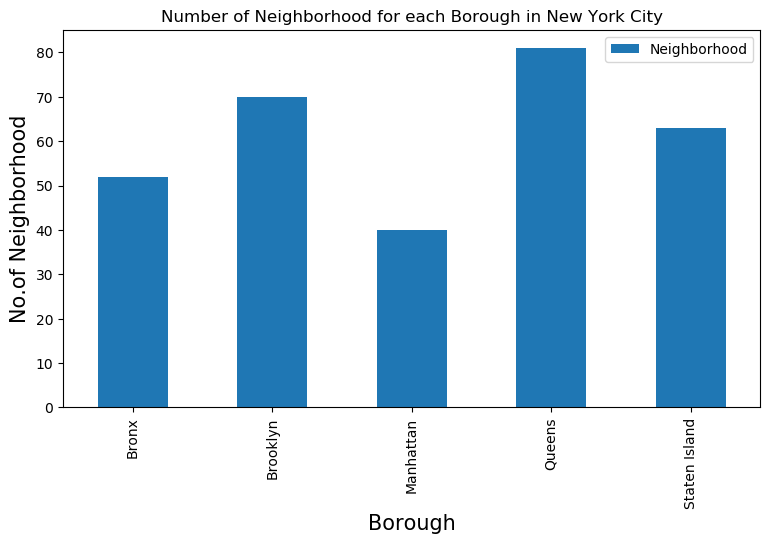

In [12]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Sushi resturants for each Neighborhood

In [17]:
# prepare neighborhood list that contains sushi resturants

column_names=['Borough', 'Neighborhood', 'ID','Name']
sushi_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    sushi_resturants=venues[venues['Category']=='Sushi Restaurant']   
    print('(',count,'/',len(new_york_data),')','Sushi Resturants in '+Neighborhood+', '+Borough+':'+str(len(sushi_resturants)))
    for resturant_detail in sushi_resturants.values.tolist():
        id, name , category=resturant_detail
        sushi_rest_ny = sushi_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Sushi Resturants in Wakefield, Bronx:0
( 2 / 306 ) Sushi Resturants in Co-op City, Bronx:0
( 3 / 306 ) Sushi Resturants in Eastchester, Bronx:0
( 4 / 306 ) Sushi Resturants in Fieldston, Bronx:1
( 5 / 306 ) Sushi Resturants in Riverdale, Bronx:0
( 6 / 306 ) Sushi Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Sushi Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Sushi Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Sushi Resturants in Norwood, Bronx:0
( 10 / 306 ) Sushi Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Sushi Resturants in Baychester, Bronx:0
( 12 / 306 ) Sushi Resturants in Pelham Parkway, Bronx:1
( 13 / 306 ) Sushi Resturants in City Island, Bronx:0
( 14 / 306 ) Sushi Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Sushi Resturants in University Heights, Bronx:0
( 16 / 306 ) Sushi Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Sushi Resturants in Fordham, Bronx:0
( 18 / 306 ) Sushi Resturants in East Tremont, Bronx:0
( 19 / 306 ) Sushi Resturants in W

In [34]:
sushi_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Fieldston,5500e02c498e2814defb4877,Asian Tokyo
1,Bronx,Pelham Parkway,4c45c922f97fbe9a9e02bd30,Kiraku Hibachi & Sushi
2,Bronx,Country Club,4bbfc5a974a9a5935519cff6,Sushi Q
3,Bronx,Morris Park,4c45c922f97fbe9a9e02bd30,Kiraku Hibachi & Sushi
4,Bronx,North Riverdale,4baa9c97f964a52088793ae3,Tokyo House


In [18]:
sushi_rest_ny.shape

(196, 4)

We got 196 Sushi Resturants across New York City

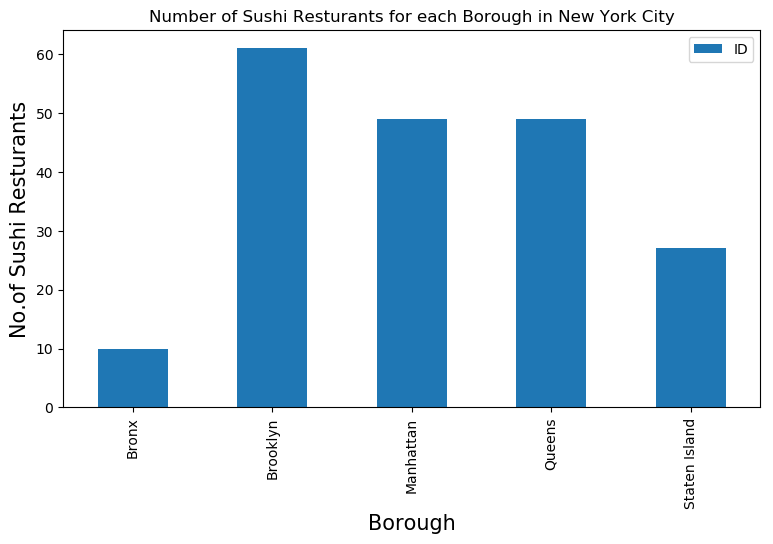

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Sushi Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Sushi Resturants', fontsize=15)
#giving a bar plot
sushi_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Brooklyn has the largest number of Sushi resturants

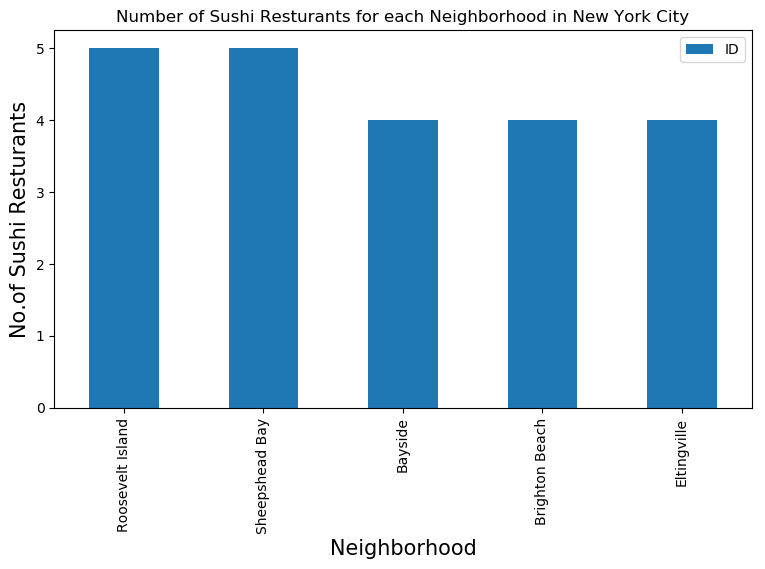

In [29]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Sushi Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Sushi Resturants', fontsize=15)
#giving a bar plot
sushi_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [32]:
sushi_rest_ny[sushi_rest_ny['Neighborhood']=='Sheepshead Bay']


,Borough,Neighborhood,ID,Name
19,Brooklyn,Sheepshead Bay,4b9fc706f964a520cc3d37e3,Mitoushi Sushi
20,Brooklyn,Sheepshead Bay,4ba3ed56f964a520556e38e3,Hayashi
21,Brooklyn,Sheepshead Bay,4ada2ec4f964a520a61f21e3,Masakari
22,Brooklyn,Sheepshead Bay,4b6625e5f964a52052162be3,Ginza Sushi Inc
23,Brooklyn,Sheepshead Bay,4fd2bdbce4b0191b9b9e9c2a,Chikurin Sushi


In [33]:
sushi_rest_ny[sushi_rest_ny['Neighborhood']=='Roosevelt Island']

,Borough,Neighborhood,ID,Name
75,Manhattan,Roosevelt Island,501adf11e4b0d225f8788a03,Tanoshi Sushi
76,Manhattan,Roosevelt Island,593747b672475054e94bd3d4,Sushi Ishikawa
77,Manhattan,Roosevelt Island,59a0a55725fb7b0552213ca6,Zawa
78,Manhattan,Roosevelt Island,43713c00f964a520fe291fe3,Matsu Sushi
79,Manhattan,Roosevelt Island,4ac28e92f964a520b79920e3,Sushi Seki UES


So Sheepshead Bay and Roosevelt Island in Brooklyn have the highest number of Indian Resturants with a total count of 5 each one.

Now we will get the ranking of each resturant for further analysis.

In [60]:
# prepare neighborhood list that contains sushi resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
sushi_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in sushi_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(sushi_rest_ny),')','processed')
    sushi_rest_stats_ny = sushi_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5500e02c498e2814defb4877
( 1 / 196 ) processed
                         ID                    Name  Likes  Rating  Tips
0  4c45c922f97fbe9a9e02bd30  Kiraku Hibachi & Sushi     12     7.8    10
( 2 / 196 ) processed
                         ID     Name  Likes  Rating  Tips
0  4bbfc5a974a9a5935519cff6  Sushi Q     13     7.7     9
( 3 / 196 ) processed
                         ID                    Name  Likes  Rating  Tips
0  4c45c922f97fbe9a9e02bd30  Kiraku Hibachi & Sushi     12     7.8    10
( 4 / 196 ) processed
                         ID         Name  Likes  Rating  Tips
0  4baa9c97f964a52088793ae3  Tokyo House     15     7.4     7
( 5 / 196 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b5382b4f964a5205fa027e3
( 6 / 196 ) processed
                         ID     Name  Likes  Rating  Tips
0  4bbfc5a974a9a5935519cff6  Sushi Q     1

In [61]:
sushi_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Fieldston,0,0,0,0,0
1,Bronx,Pelham Parkway,4c45c922f97fbe9a9e02bd30,Kiraku Hibachi & Sushi,12,7.8,10
2,Bronx,Country Club,4bbfc5a974a9a5935519cff6,Sushi Q,13,7.7,9
3,Bronx,Morris Park,4c45c922f97fbe9a9e02bd30,Kiraku Hibachi & Sushi,12,7.8,10
4,Bronx,North Riverdale,4baa9c97f964a52088793ae3,Tokyo House,15,7.4,7


In [62]:
sushi_rest_stats_ny.shape

(196, 7)

In [63]:
sushi_rest_ny.shape

(196, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [64]:
sushi_rest_stats_ny.to_csv('sushi_rest_stats_ny.csv', index=False)

In [65]:
sushi_rest_stats_ny_csv=pd.read_csv('sushi_rest_stats_ny.csv')

In [66]:
sushi_rest_stats_ny_csv.shape

(196, 7)

In [67]:
sushi_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Fieldston,0,0,0,0.0,0
1,Bronx,Pelham Parkway,4c45c922f97fbe9a9e02bd30,Kiraku Hibachi & Sushi,12,7.8,10
2,Bronx,Country Club,4bbfc5a974a9a5935519cff6,Sushi Q,13,7.7,9
3,Bronx,Morris Park,4c45c922f97fbe9a9e02bd30,Kiraku Hibachi & Sushi,12,7.8,10
4,Bronx,North Riverdale,4baa9c97f964a52088793ae3,Tokyo House,15,7.4,7


In [68]:
sushi_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 7 columns):
Borough         196 non-null object
Neighborhood    196 non-null object
ID              196 non-null object
Name            196 non-null object
Likes           196 non-null object
Rating          196 non-null object
Tips            196 non-null object
dtypes: object(7)
memory usage: 10.8+ KB


We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [69]:
sushi_rest_stats_ny['Likes']=sushi_rest_stats_ny['Likes'].astype('float64')

In [70]:
sushi_rest_stats_ny['Tips']=sushi_rest_stats_ny['Tips'].astype('float64')

In [74]:
sushi_rest_stats_ny['Rating']=sushi_rest_stats_ny['Rating'].astype('float64')

In [75]:
sushi_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 7 columns):
Borough         196 non-null object
Neighborhood    196 non-null object
ID              196 non-null object
Name            196 non-null object
Likes           196 non-null float64
Rating          196 non-null float64
Tips            196 non-null float64
dtypes: float64(3), object(4)
memory usage: 10.8+ KB


Now the data types looks correct

In [72]:
# Resturant with maximum Likes
sushi_rest_stats_ny.iloc[sushi_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              49d991d9f964a5204a5e1fe3
Name                              Momoya
Likes                                771
Rating                               9.2
Tips                                 241
Name: 86, dtype: object

In [76]:
# Resturant with maximum Rating
sushi_rest_stats_ny.iloc[sushi_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                    Flatiron
ID              5a0e475b018cbb6a2196479e
Name                        Sushi By Bou
Likes                                 78
Rating                               9.4
Tips                                  13
Name: 175, dtype: object

In [49]:

# Resturant with maximum Tips
sushi_rest_stats_ny.iloc[sushi_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                Williamsburg
ID              423e0e80f964a52048201fe3
Name                                Bozu
Likes                                506
Rating                               9.1
Tips                                 166
Name: 35, dtype: object

In [78]:
ny_neighborhood_stats=sushi_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [79]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
92,Soho,9.30
35,Flatiron,9.30
45,Greenwich Village,9.25
104,West Village,9.20
65,Midtown,9.20
21,Chelsea,9.20
107,Williamsburg,9.10
93,South Side,9.10
74,North Side,9.10
55,Lincoln Square,9.05


Above are the top neighborhoods with top average rating of Sushi resturants

In [80]:
ny_borough_stats=sushi_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [81]:

ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.553061
3,Queens,7.069388
1,Brooklyn,7.059016
0,Bronx,5.980000
4,Staten Island,5.951852


Similarly these are the average rating of Sushi Resturants for each Borough

Lets visualize it

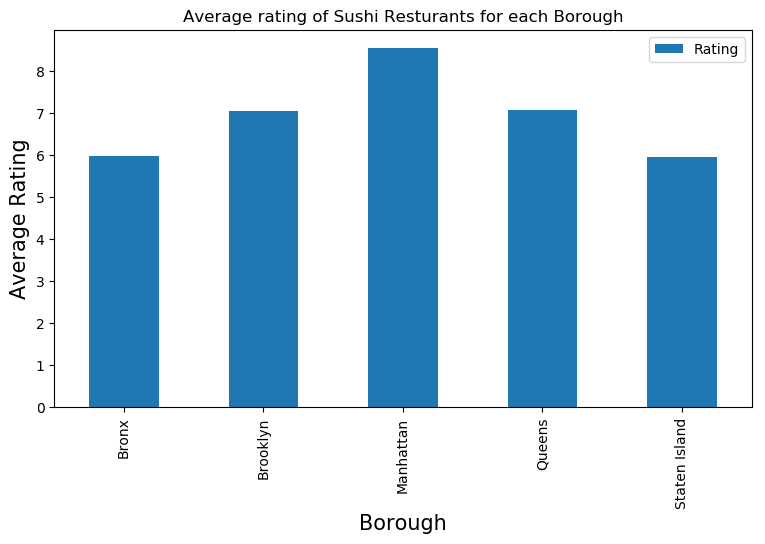

In [82]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Sushi Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
sushi_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [83]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [84]:
ny_neighborhood_stats

,Neighborhood,Average Rating
21,Chelsea,9.20
22,Civic Center,9.00
35,Flatiron,9.30
45,Greenwich Village,9.25
55,Lincoln Square,9.05
65,Midtown,9.20
74,North Side,9.10
92,Soho,9.30
93,South Side,9.10
99,Tribeca,9.00


In [85]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [86]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [87]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.20
1,Staten Island,Chelsea,40.594726,-74.189560,9.20
2,Manhattan,Civic Center,40.715229,-74.005415,9.00
3,Manhattan,Flatiron,40.739673,-73.990947,9.30
4,Manhattan,Greenwich Village,40.726933,-73.999914,9.25
5,Manhattan,Lincoln Square,40.773529,-73.985338,9.05
6,Manhattan,Midtown,40.754691,-73.981669,9.20
7,Brooklyn,North Side,40.714823,-73.958809,9.10
8,Manhattan,Soho,40.722184,-74.000657,9.30
9,Brooklyn,South Side,40.710861,-73.958001,9.10


In [88]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [89]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [90]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [91]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)


Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating

In [92]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

FileNotFoundError: [Errno 2] No such file or directory: 'Borough Boundaries.geojson'

## Conclusion

XXXXXXXXXXXXXXXXXXXXXXXXX are some of the best neighborhoods for Sushi cuisine.
Manhattan have potential Sushi Resturant Market/
XXXXXXX ranks last in average rating of Sushi Resturants.
Manhattan is the best place to stay if you prefer Indian Cuisine.

Limitations

The ranking is purely on basis of rating of resturants
The accuracy of data depends purely depends on the data provided by FourSquare